In [1]:
#This notebook performs Step 1 of the RNN training process: time-warping the single letter data so that it
#can be used to initialize the data-labeling HMM. Running this notebook will (slowly) time-warp all 10 sessions
#and save the results in Step1_TimeWarping folder.

#To run this notebook, you'll need the time warped PCA python package (https://github.com/ganguli-lab/twpca).

In [8]:
import tensorflow as tf
tf.compat.v1.disable_v2_behavior()

#suppress all tensorflow warnings (largely related to compatability with v2)
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

import os
import numpy as np
import scipy.io
import scipy.ndimage.filters
import matplotlib.pyplot as plt
from twpca import TWPCA
from twpca.regularizers import curvature

#point this towards the top level dataset directory
rootDir = os.path.expanduser('~') + '/clones/willets-2021-handwriting-bci'

#this line ensures that tensorflow will only use GPU 0 (keeps it from taking over all the GPUs in a multi-gpu setup)
os.environ["CUDA_VISIBLE_DEVICES"]='0'

#defines all the sessions that will be time-warped
dataDirs = ['t5.2019.05.08']

#saves all time-warped data in this folder
if not os.path.isdir(rootDir + 'warped-data'):
    os.mkdir(rootDir + 'warped-data')

In [15]:
#--Can add new definitions here to apply this code to other problems or datasets.--
import numpy as np

def getHandwritingCharacterDefinitions():
    """
    Returns a dictionary with entries that define the names of each character, its length, and where the pen tip begins.
    
    Returns:
        charDef (dict)
    """
        
    charDef = {}
    
    #Define the list of all 31 characters and their names.
    charDef['charList'] = ['a','b','c','d','e','f','g','h','i','j','k','l','m','n','o','p','q','r','s','t','u','v','w','x','y','z',
                'greaterThan','comma','apostrophe','tilde','questionMark']
    charDef['charListAbbr'] = ['a','b','c','d','e','f','g','h','i','j','k','l','m','n','o','p','q','r','s','t','u','v','w','x','y','z',
                '>',',',"'",'~','?']

    #Define the length of each character (in # of 10 ms bins) to use for each template.
    #These were hand-defined based on visual inspection of the reconstructed pen trajectories.
    charDef['charLen'] = np.array([99, 91, 70, 104, 98, 125, 110, 104, 79, 92, 127, 68, 132, 90, 
                        84, 113, 104, 74, 86, 110, 86, 83, 110, 103, 115, 100, 82, 77, 116, 71, 110]).astype(np.int32)
    
    #For each character, this defines the starting location of the pen tip (0 = bottom of the line, 1 = top)
    charDef['penStart'] = [0.25, 1, 0.5, 0.5, 0.25, 1.0, 0.25, 1.0, 0.5, 0.5, 1, 1, 0.5, 0.5, 0.25, 0.5, 0.25, 0.5, 0.5, 1, 
           0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.25, 1, 0.5, 1]
    
    #dictionary to convert string representation to character index
    charDef['strToCharIdx'] = {}
    for x in range(len(charDef['charListAbbr'])):
        charDef['strToCharIdx'][charDef['charListAbbr'][x]] = x
        
    #ordering of characters that kaldi (i.e., the language model) expects
    charDef['kaldiOrder'] = ['<ctc>','>',"'",',','.','?','a','b','c','d','e','f','g','h','i','j',
                             'k','l','m','n','o','p','q','r','s','t','u','v','w','x','y','z']
    
    #re-indexing to match kaldi order (e.g., outputs[:,:,charDef['idxToKaldi']] places the output in kald-order)
    charDef['idxToKaldi'] = np.array([31,26,28,27,29,30,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,
                                     21,22,23,24,25]).astype(np.int32)
    
    return charDef

charDef = getHandwritingCharacterDefinitions()

In [17]:
import tarfile
# Path to the tar file and the target file inside it
tar_path = 'handwritingBCIData.tar'
target_mat_path = './handwritingBCIData/Datasets/t5.2019.05.08/singleLetters.mat'

# Open the tar file
with tarfile.open(tar_path, 'r') as tar:
    # Get the file object
    mat_member = tar.getmember(target_mat_path)
    mat_file = tar.extractfile(mat_member)
    
    # Load the .mat file
    if mat_file is not None:
        dat = scipy.io.loadmat(mat_file)

Warping dataset: t5.2019.05.08
Warping character: a


/var/folders/n_/8p1gdnb570j4m06ltsyf5d1w0000gn/T/ipykernel_77119/1514026267.py:54: DeprecationWarning: Please import `gaussian_filter1d` from the `scipy.ndimage` namespace; the `scipy.ndimage.filters` namespace is deprecated and will be removed in SciPy 2.0.0.
  smoothed_spikes = scipy.ndimage.filters.gaussian_filter1d(dat['neuralActivityCube_'+char], 3.0, axis=1)
2025-06-16 21:31:02.289976: W tensorflow/c/c_api.cc:305] Operation '{name:'tau_scale_31/Assign' id:803599 op device:{requested: '', assigned: ''} def:{{{node tau_scale_31/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](tau_scale_31, tau_scale_31/Initializer/initial_value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2025-06-16 21:31:30.388179: W tensorflow/c/c_api.cc:305] Operation '{name:'tau_shift_31/Ad

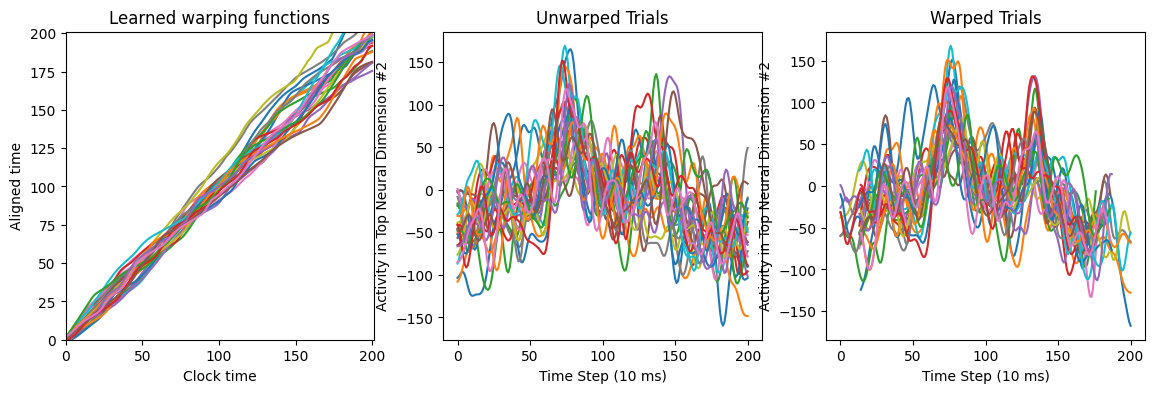

Warping character: b


/var/folders/n_/8p1gdnb570j4m06ltsyf5d1w0000gn/T/ipykernel_77119/1514026267.py:54: DeprecationWarning: Please import `gaussian_filter1d` from the `scipy.ndimage` namespace; the `scipy.ndimage.filters` namespace is deprecated and will be removed in SciPy 2.0.0.
  smoothed_spikes = scipy.ndimage.filters.gaussian_filter1d(dat['neuralActivityCube_'+char], 3.0, axis=1)
2025-06-16 21:32:21.606040: W tensorflow/c/c_api.cc:305] Operation '{name:'tau_scale_32/Assign' id:830337 op device:{requested: '', assigned: ''} def:{{{node tau_scale_32/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](tau_scale_32, tau_scale_32/Initializer/initial_value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2025-06-16 21:32:50.906500: W tensorflow/c/c_api.cc:305] Operation '{name:'tau_shift_32/Ad

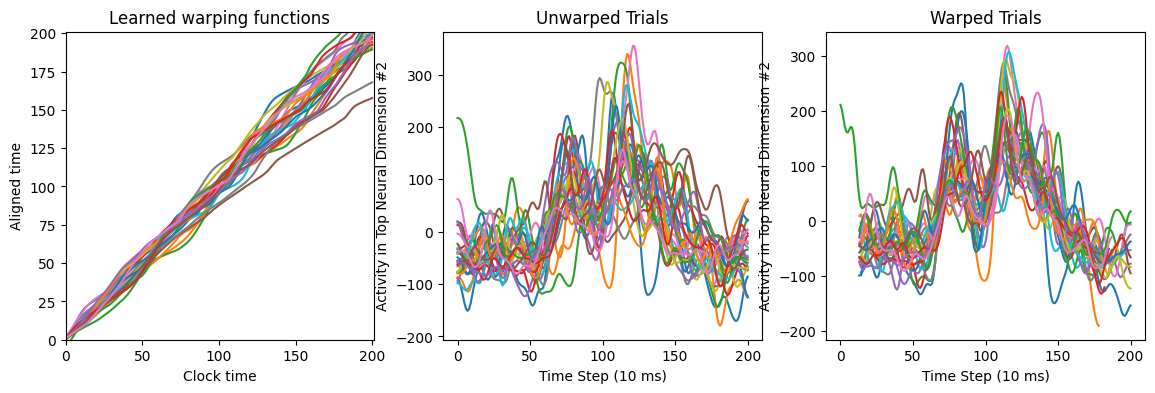

Warping character: c


/var/folders/n_/8p1gdnb570j4m06ltsyf5d1w0000gn/T/ipykernel_77119/1514026267.py:54: DeprecationWarning: Please import `gaussian_filter1d` from the `scipy.ndimage` namespace; the `scipy.ndimage.filters` namespace is deprecated and will be removed in SciPy 2.0.0.
  smoothed_spikes = scipy.ndimage.filters.gaussian_filter1d(dat['neuralActivityCube_'+char], 3.0, axis=1)
2025-06-16 21:33:47.006984: W tensorflow/c/c_api.cc:305] Operation '{name:'tau_scale_33/Assign' id:857126 op device:{requested: '', assigned: ''} def:{{{node tau_scale_33/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](tau_scale_33, tau_scale_33/Initializer/initial_value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2025-06-16 21:34:17.890189: W tensorflow/c/c_api.cc:305] Operation '{name:'tau_shift_33/Ad

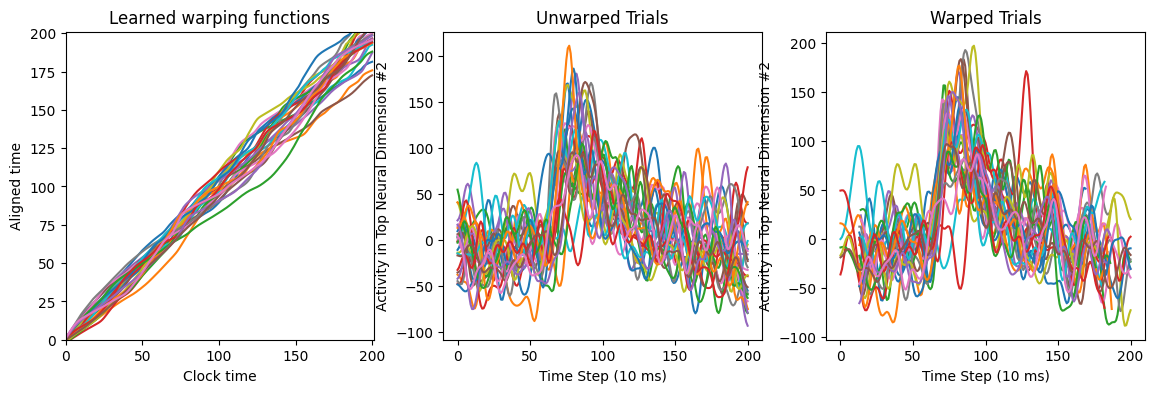

Warping character: d


/var/folders/n_/8p1gdnb570j4m06ltsyf5d1w0000gn/T/ipykernel_77119/1514026267.py:54: DeprecationWarning: Please import `gaussian_filter1d` from the `scipy.ndimage` namespace; the `scipy.ndimage.filters` namespace is deprecated and will be removed in SciPy 2.0.0.
  smoothed_spikes = scipy.ndimage.filters.gaussian_filter1d(dat['neuralActivityCube_'+char], 3.0, axis=1)
2025-06-16 21:35:13.479800: W tensorflow/c/c_api.cc:305] Operation '{name:'tau_scale_34/Assign' id:883966 op device:{requested: '', assigned: ''} def:{{{node tau_scale_34/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](tau_scale_34, tau_scale_34/Initializer/initial_value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2025-06-16 21:35:44.763247: W tensorflow/c/c_api.cc:305] Operation '{name:'tau_shift_34/Ad

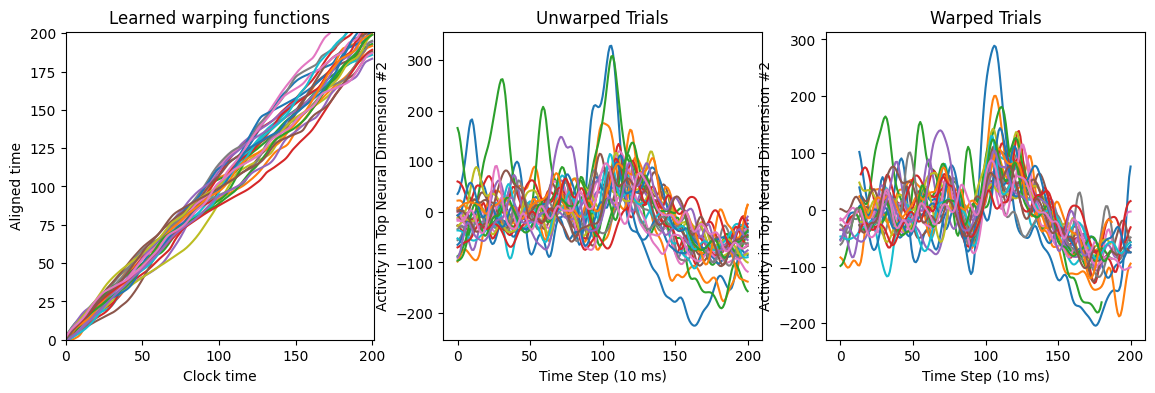

Warping character: e


/var/folders/n_/8p1gdnb570j4m06ltsyf5d1w0000gn/T/ipykernel_77119/1514026267.py:54: DeprecationWarning: Please import `gaussian_filter1d` from the `scipy.ndimage` namespace; the `scipy.ndimage.filters` namespace is deprecated and will be removed in SciPy 2.0.0.
  smoothed_spikes = scipy.ndimage.filters.gaussian_filter1d(dat['neuralActivityCube_'+char], 3.0, axis=1)
2025-06-16 21:36:41.662696: W tensorflow/c/c_api.cc:305] Operation '{name:'tau_scale_35/Assign' id:910857 op device:{requested: '', assigned: ''} def:{{{node tau_scale_35/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](tau_scale_35, tau_scale_35/Initializer/initial_value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2025-06-16 21:37:14.616274: W tensorflow/c/c_api.cc:305] Operation '{name:'tau_shift_35/Ad

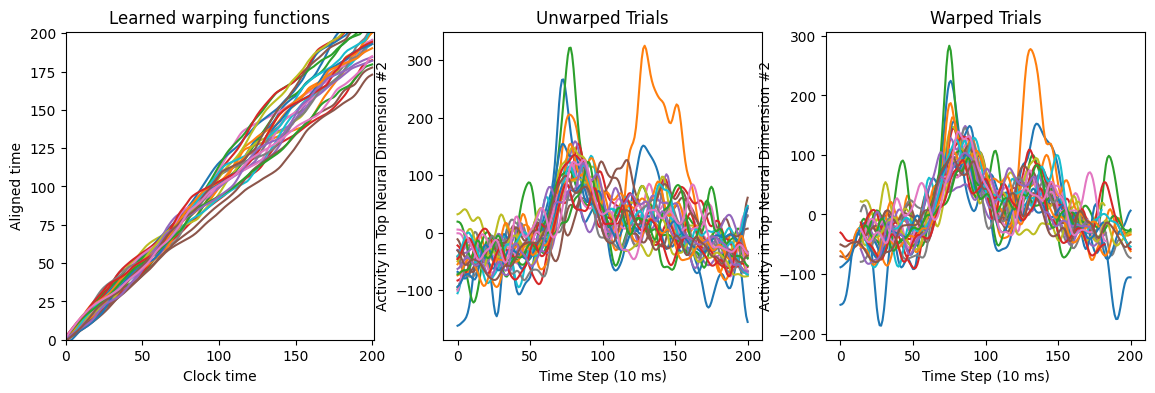

Warping character: f


/var/folders/n_/8p1gdnb570j4m06ltsyf5d1w0000gn/T/ipykernel_77119/1514026267.py:54: DeprecationWarning: Please import `gaussian_filter1d` from the `scipy.ndimage` namespace; the `scipy.ndimage.filters` namespace is deprecated and will be removed in SciPy 2.0.0.
  smoothed_spikes = scipy.ndimage.filters.gaussian_filter1d(dat['neuralActivityCube_'+char], 3.0, axis=1)
2025-06-16 21:38:14.621463: W tensorflow/c/c_api.cc:305] Operation '{name:'tau_scale_36/Assign' id:937799 op device:{requested: '', assigned: ''} def:{{{node tau_scale_36/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](tau_scale_36, tau_scale_36/Initializer/initial_value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2025-06-16 21:38:49.025314: W tensorflow/c/c_api.cc:305] Operation '{name:'tau_shift_36/Ad

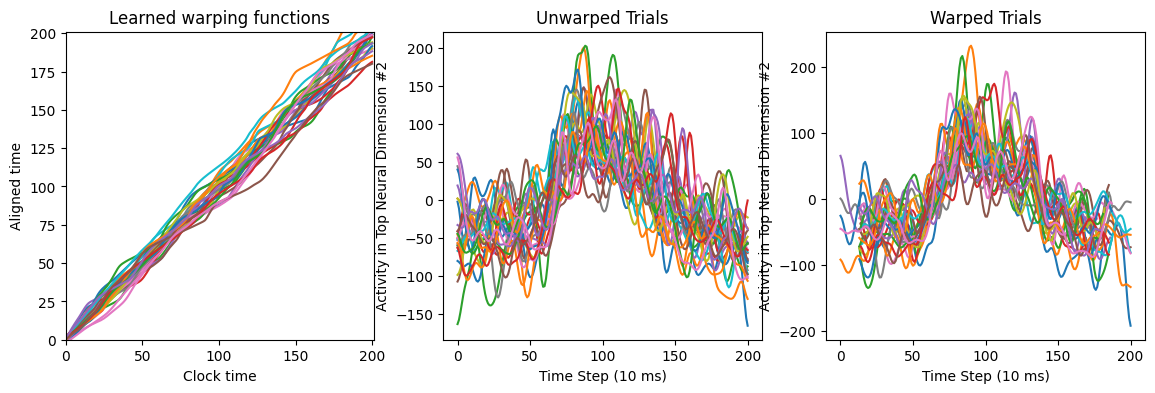

Warping character: g


/var/folders/n_/8p1gdnb570j4m06ltsyf5d1w0000gn/T/ipykernel_77119/1514026267.py:54: DeprecationWarning: Please import `gaussian_filter1d` from the `scipy.ndimage` namespace; the `scipy.ndimage.filters` namespace is deprecated and will be removed in SciPy 2.0.0.
  smoothed_spikes = scipy.ndimage.filters.gaussian_filter1d(dat['neuralActivityCube_'+char], 3.0, axis=1)
2025-06-16 21:39:51.417131: W tensorflow/c/c_api.cc:305] Operation '{name:'tau_scale_37/Assign' id:964792 op device:{requested: '', assigned: ''} def:{{{node tau_scale_37/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](tau_scale_37, tau_scale_37/Initializer/initial_value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2025-06-16 21:40:27.485593: W tensorflow/c/c_api.cc:305] Operation '{name:'tau_shift_37/Ad

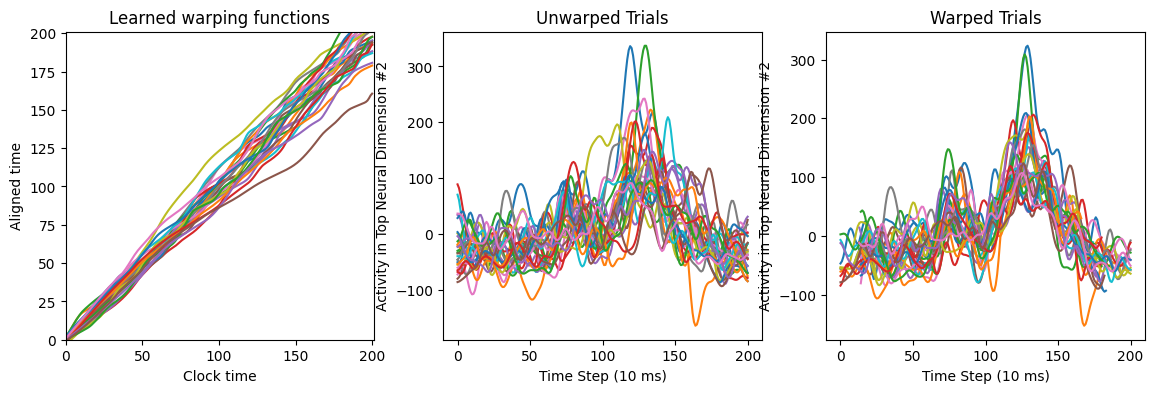

Warping character: h


/var/folders/n_/8p1gdnb570j4m06ltsyf5d1w0000gn/T/ipykernel_77119/1514026267.py:54: DeprecationWarning: Please import `gaussian_filter1d` from the `scipy.ndimage` namespace; the `scipy.ndimage.filters` namespace is deprecated and will be removed in SciPy 2.0.0.
  smoothed_spikes = scipy.ndimage.filters.gaussian_filter1d(dat['neuralActivityCube_'+char], 3.0, axis=1)
2025-06-16 21:41:30.214063: W tensorflow/c/c_api.cc:305] Operation '{name:'tau_scale_38/Assign' id:991836 op device:{requested: '', assigned: ''} def:{{{node tau_scale_38/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](tau_scale_38, tau_scale_38/Initializer/initial_value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2025-06-16 21:42:06.615364: W tensorflow/c/c_api.cc:305] Operation '{name:'tau_shift_38/Ad

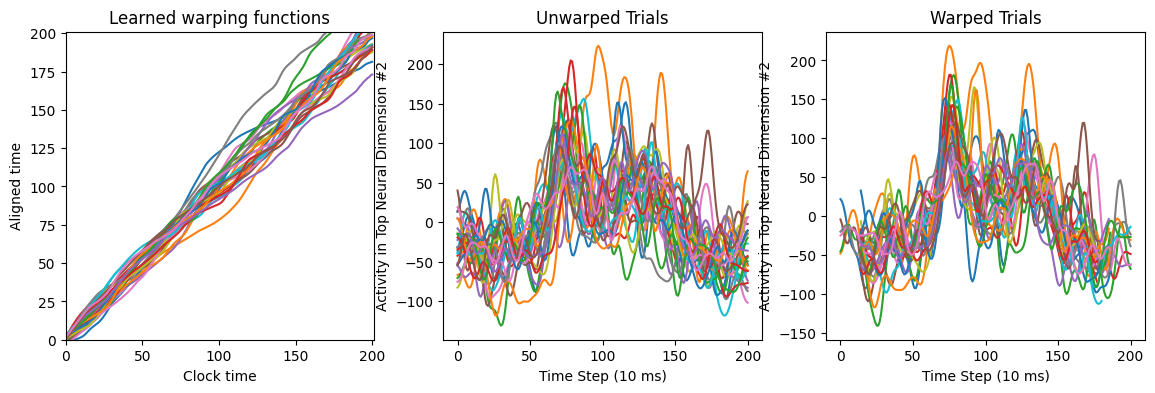

Warping character: i


/var/folders/n_/8p1gdnb570j4m06ltsyf5d1w0000gn/T/ipykernel_77119/1514026267.py:54: DeprecationWarning: Please import `gaussian_filter1d` from the `scipy.ndimage` namespace; the `scipy.ndimage.filters` namespace is deprecated and will be removed in SciPy 2.0.0.
  smoothed_spikes = scipy.ndimage.filters.gaussian_filter1d(dat['neuralActivityCube_'+char], 3.0, axis=1)
2025-06-16 21:43:12.488124: W tensorflow/c/c_api.cc:305] Operation '{name:'tau_scale_39/Assign' id:1018931 op device:{requested: '', assigned: ''} def:{{{node tau_scale_39/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](tau_scale_39, tau_scale_39/Initializer/initial_value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2025-06-16 21:43:50.494964: W tensorflow/c/c_api.cc:305] Operation '{name:'tau_shift_39/A

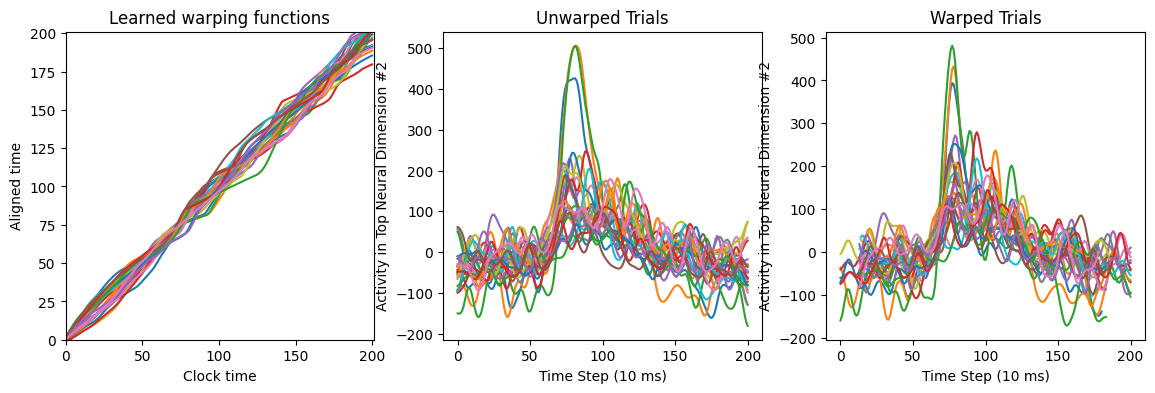

Warping character: j


/var/folders/n_/8p1gdnb570j4m06ltsyf5d1w0000gn/T/ipykernel_77119/1514026267.py:54: DeprecationWarning: Please import `gaussian_filter1d` from the `scipy.ndimage` namespace; the `scipy.ndimage.filters` namespace is deprecated and will be removed in SciPy 2.0.0.
  smoothed_spikes = scipy.ndimage.filters.gaussian_filter1d(dat['neuralActivityCube_'+char], 3.0, axis=1)
2025-06-16 21:44:58.072694: W tensorflow/c/c_api.cc:305] Operation '{name:'tau_scale_40/Assign' id:1046077 op device:{requested: '', assigned: ''} def:{{{node tau_scale_40/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](tau_scale_40, tau_scale_40/Initializer/initial_value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2025-06-16 21:45:37.410817: W tensorflow/c/c_api.cc:305] Operation '{name:'tau_shift_40/A

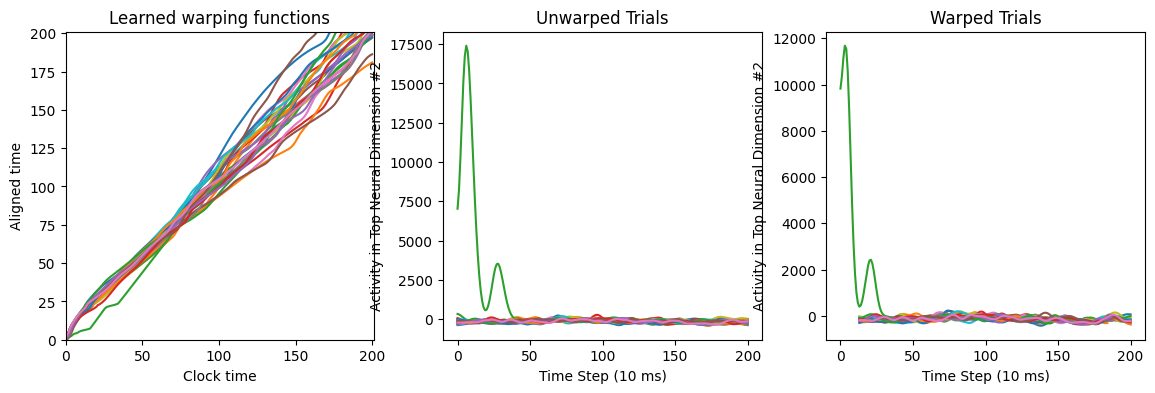

Warping character: k


/var/folders/n_/8p1gdnb570j4m06ltsyf5d1w0000gn/T/ipykernel_77119/1514026267.py:54: DeprecationWarning: Please import `gaussian_filter1d` from the `scipy.ndimage` namespace; the `scipy.ndimage.filters` namespace is deprecated and will be removed in SciPy 2.0.0.
  smoothed_spikes = scipy.ndimage.filters.gaussian_filter1d(dat['neuralActivityCube_'+char], 3.0, axis=1)
2025-06-16 21:46:47.256827: W tensorflow/c/c_api.cc:305] Operation '{name:'tau_scale_41/Assign' id:1073274 op device:{requested: '', assigned: ''} def:{{{node tau_scale_41/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](tau_scale_41, tau_scale_41/Initializer/initial_value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2025-06-16 21:47:27.953699: W tensorflow/c/c_api.cc:305] Operation '{name:'tau_shift_41/A

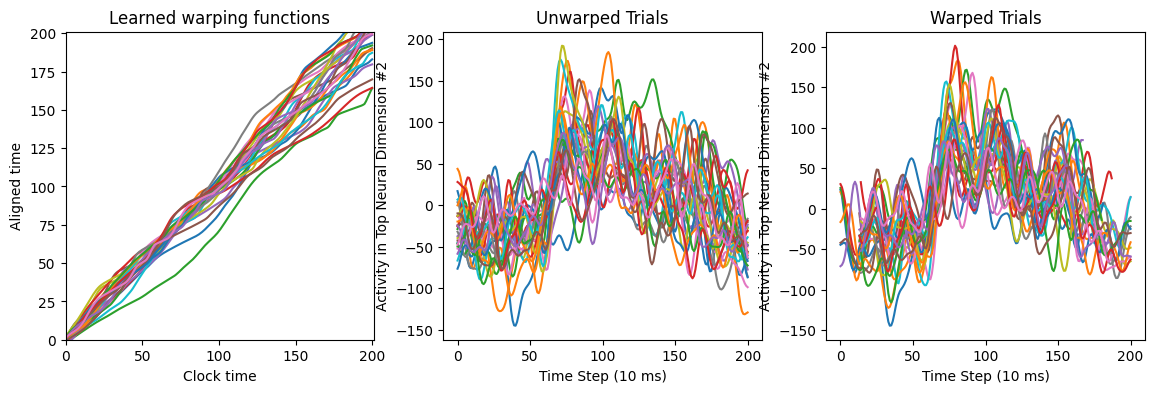

Warping character: l


/var/folders/n_/8p1gdnb570j4m06ltsyf5d1w0000gn/T/ipykernel_77119/1514026267.py:54: DeprecationWarning: Please import `gaussian_filter1d` from the `scipy.ndimage` namespace; the `scipy.ndimage.filters` namespace is deprecated and will be removed in SciPy 2.0.0.
  smoothed_spikes = scipy.ndimage.filters.gaussian_filter1d(dat['neuralActivityCube_'+char], 3.0, axis=1)
2025-06-16 21:48:39.725731: W tensorflow/c/c_api.cc:305] Operation '{name:'tau_scale_42/Assign' id:1100522 op device:{requested: '', assigned: ''} def:{{{node tau_scale_42/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](tau_scale_42, tau_scale_42/Initializer/initial_value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2025-06-16 21:49:20.830264: W tensorflow/c/c_api.cc:305] Operation '{name:'tau_shift_42/A

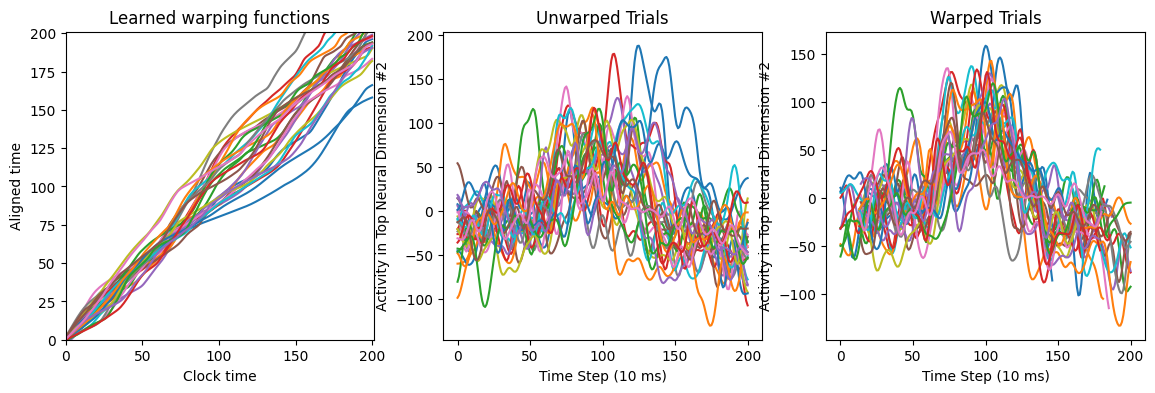

Warping character: m


/var/folders/n_/8p1gdnb570j4m06ltsyf5d1w0000gn/T/ipykernel_77119/1514026267.py:54: DeprecationWarning: Please import `gaussian_filter1d` from the `scipy.ndimage` namespace; the `scipy.ndimage.filters` namespace is deprecated and will be removed in SciPy 2.0.0.
  smoothed_spikes = scipy.ndimage.filters.gaussian_filter1d(dat['neuralActivityCube_'+char], 3.0, axis=1)
2025-06-16 21:50:33.450391: W tensorflow/c/c_api.cc:305] Operation '{name:'tau_scale_43/Assign' id:1127821 op device:{requested: '', assigned: ''} def:{{{node tau_scale_43/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](tau_scale_43, tau_scale_43/Initializer/initial_value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2025-06-16 21:51:15.337609: W tensorflow/c/c_api.cc:305] Operation '{name:'tau_shift_43/A

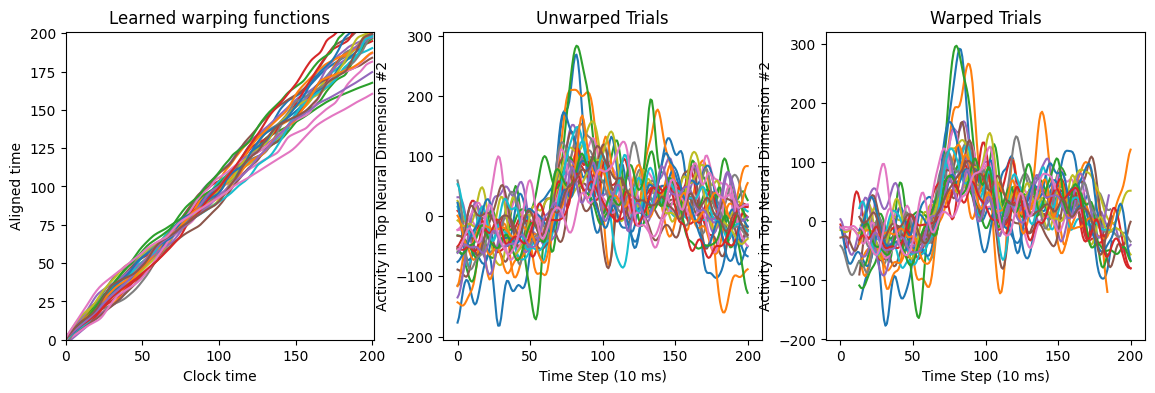

Warping character: n


/var/folders/n_/8p1gdnb570j4m06ltsyf5d1w0000gn/T/ipykernel_77119/1514026267.py:54: DeprecationWarning: Please import `gaussian_filter1d` from the `scipy.ndimage` namespace; the `scipy.ndimage.filters` namespace is deprecated and will be removed in SciPy 2.0.0.
  smoothed_spikes = scipy.ndimage.filters.gaussian_filter1d(dat['neuralActivityCube_'+char], 3.0, axis=1)
2025-06-16 21:52:31.985717: W tensorflow/c/c_api.cc:305] Operation '{name:'tau_scale_44/Assign' id:1155171 op device:{requested: '', assigned: ''} def:{{{node tau_scale_44/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](tau_scale_44, tau_scale_44/Initializer/initial_value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2025-06-16 21:53:16.314413: W tensorflow/c/c_api.cc:305] Operation '{name:'tau_shift_44/A

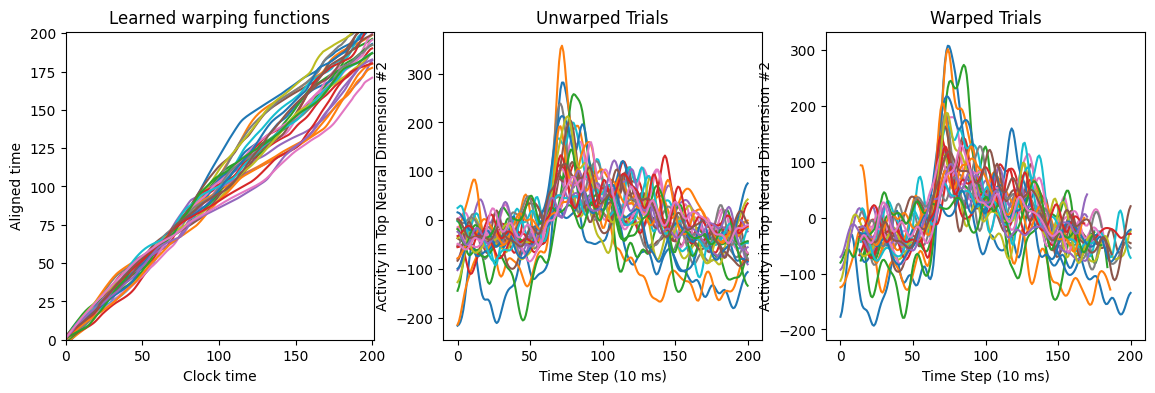

Warping character: o


/var/folders/n_/8p1gdnb570j4m06ltsyf5d1w0000gn/T/ipykernel_77119/1514026267.py:54: DeprecationWarning: Please import `gaussian_filter1d` from the `scipy.ndimage` namespace; the `scipy.ndimage.filters` namespace is deprecated and will be removed in SciPy 2.0.0.
  smoothed_spikes = scipy.ndimage.filters.gaussian_filter1d(dat['neuralActivityCube_'+char], 3.0, axis=1)
2025-06-16 21:54:34.607276: W tensorflow/c/c_api.cc:305] Operation '{name:'tau_scale_45/Assign' id:1182572 op device:{requested: '', assigned: ''} def:{{{node tau_scale_45/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](tau_scale_45, tau_scale_45/Initializer/initial_value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2025-06-16 21:55:18.338186: W tensorflow/c/c_api.cc:305] Operation '{name:'tau_shift_45/A

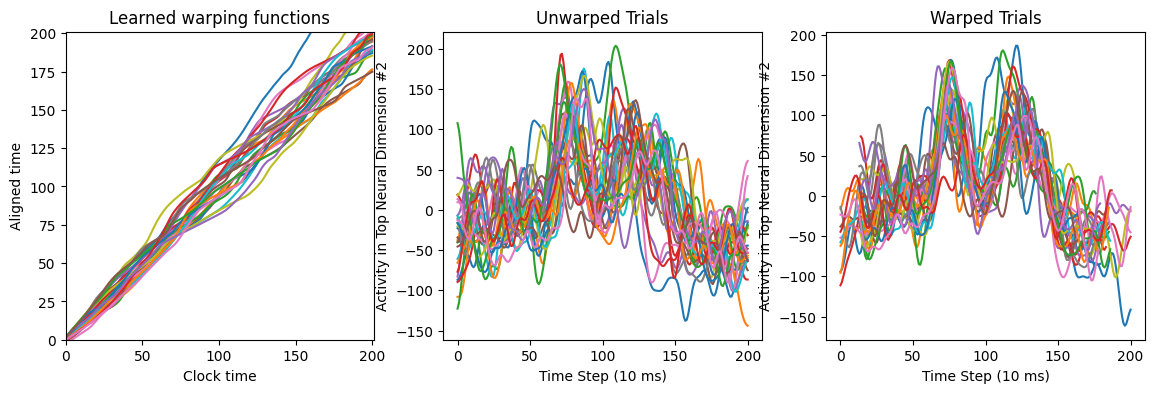

Warping character: p


/var/folders/n_/8p1gdnb570j4m06ltsyf5d1w0000gn/T/ipykernel_77119/1514026267.py:54: DeprecationWarning: Please import `gaussian_filter1d` from the `scipy.ndimage` namespace; the `scipy.ndimage.filters` namespace is deprecated and will be removed in SciPy 2.0.0.
  smoothed_spikes = scipy.ndimage.filters.gaussian_filter1d(dat['neuralActivityCube_'+char], 3.0, axis=1)
2025-06-16 21:56:39.325870: W tensorflow/c/c_api.cc:305] Operation '{name:'tau_scale_46/Assign' id:1210024 op device:{requested: '', assigned: ''} def:{{{node tau_scale_46/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](tau_scale_46, tau_scale_46/Initializer/initial_value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2025-06-16 21:57:24.139051: W tensorflow/c/c_api.cc:305] Operation '{name:'tau_shift_46/A

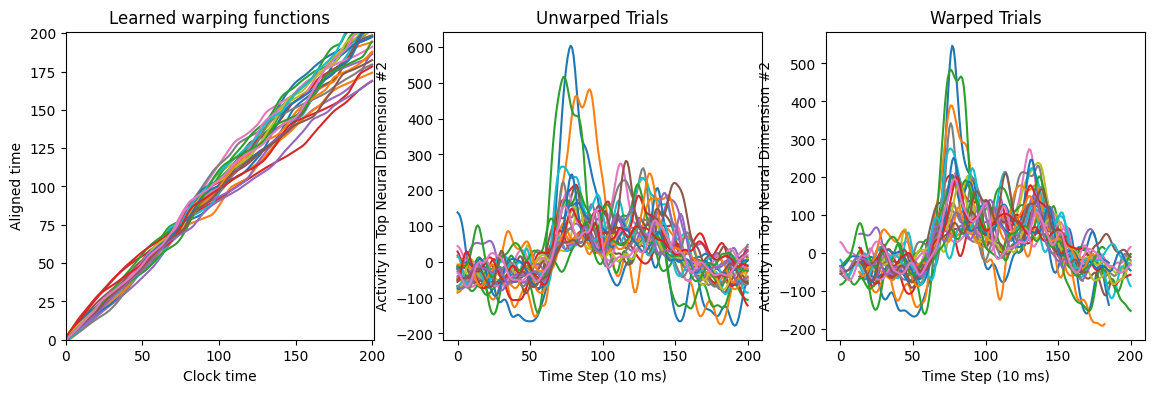

Warping character: q


/var/folders/n_/8p1gdnb570j4m06ltsyf5d1w0000gn/T/ipykernel_77119/1514026267.py:54: DeprecationWarning: Please import `gaussian_filter1d` from the `scipy.ndimage` namespace; the `scipy.ndimage.filters` namespace is deprecated and will be removed in SciPy 2.0.0.
  smoothed_spikes = scipy.ndimage.filters.gaussian_filter1d(dat['neuralActivityCube_'+char], 3.0, axis=1)
2025-06-16 21:58:45.021082: W tensorflow/c/c_api.cc:305] Operation '{name:'tau_scale_47/Assign' id:1237527 op device:{requested: '', assigned: ''} def:{{{node tau_scale_47/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](tau_scale_47, tau_scale_47/Initializer/initial_value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2025-06-16 21:59:32.016936: W tensorflow/c/c_api.cc:305] Operation '{name:'tau_shift_47/A

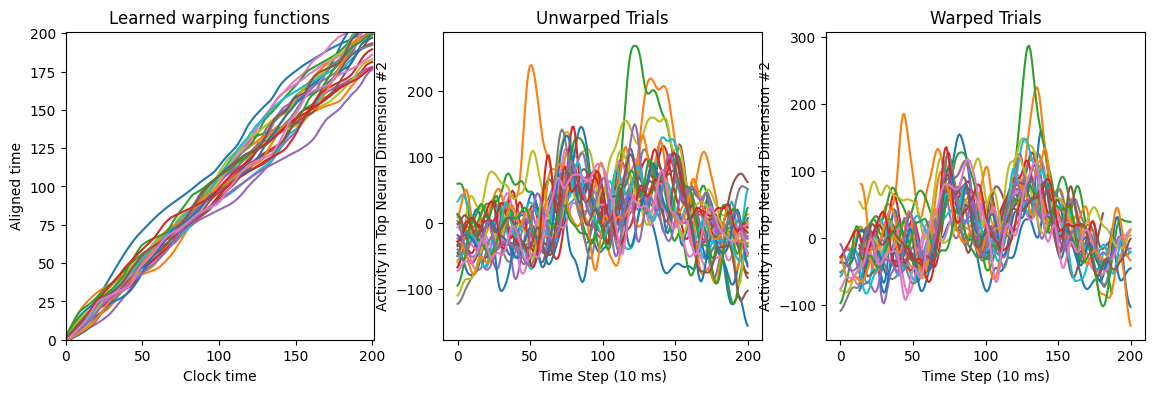

Warping character: r


/var/folders/n_/8p1gdnb570j4m06ltsyf5d1w0000gn/T/ipykernel_77119/1514026267.py:54: DeprecationWarning: Please import `gaussian_filter1d` from the `scipy.ndimage` namespace; the `scipy.ndimage.filters` namespace is deprecated and will be removed in SciPy 2.0.0.
  smoothed_spikes = scipy.ndimage.filters.gaussian_filter1d(dat['neuralActivityCube_'+char], 3.0, axis=1)
2025-06-16 22:00:55.970829: W tensorflow/c/c_api.cc:305] Operation '{name:'tau_scale_48/Assign' id:1265081 op device:{requested: '', assigned: ''} def:{{{node tau_scale_48/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](tau_scale_48, tau_scale_48/Initializer/initial_value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2025-06-16 22:01:43.650609: W tensorflow/c/c_api.cc:305] Operation '{name:'tau_shift_48/A

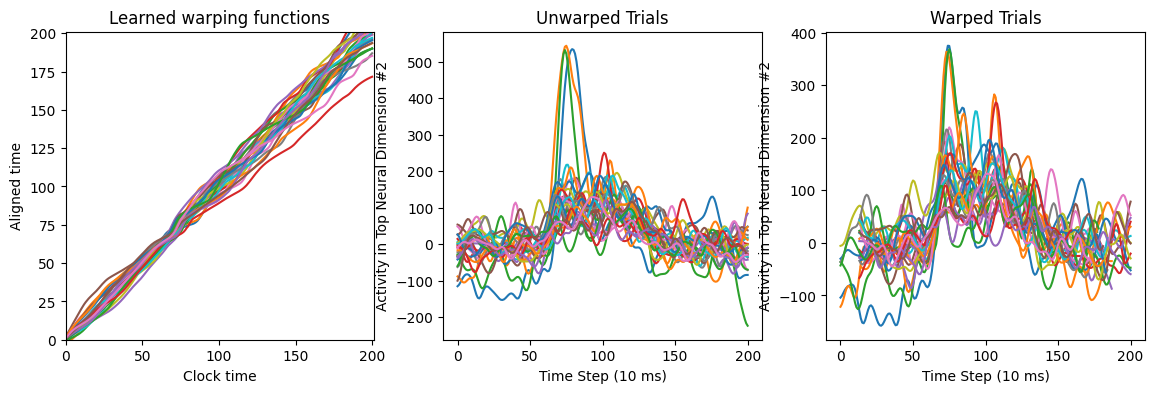

Warping character: s


/var/folders/n_/8p1gdnb570j4m06ltsyf5d1w0000gn/T/ipykernel_77119/1514026267.py:54: DeprecationWarning: Please import `gaussian_filter1d` from the `scipy.ndimage` namespace; the `scipy.ndimage.filters` namespace is deprecated and will be removed in SciPy 2.0.0.
  smoothed_spikes = scipy.ndimage.filters.gaussian_filter1d(dat['neuralActivityCube_'+char], 3.0, axis=1)
2025-06-16 22:03:09.389154: W tensorflow/c/c_api.cc:305] Operation '{name:'tau_scale_49/Assign' id:1292686 op device:{requested: '', assigned: ''} def:{{{node tau_scale_49/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](tau_scale_49, tau_scale_49/Initializer/initial_value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2025-06-16 22:03:58.045726: W tensorflow/c/c_api.cc:305] Operation '{name:'tau_shift_49/A

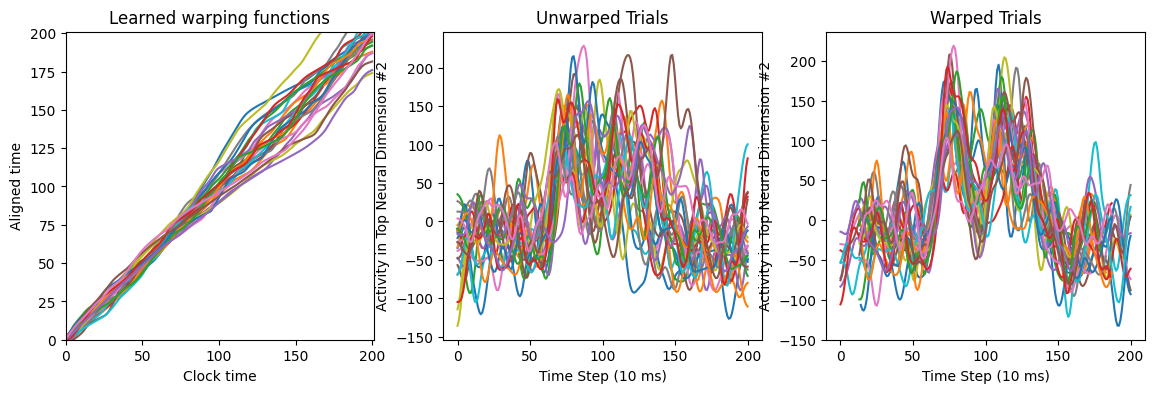

Warping character: t


/var/folders/n_/8p1gdnb570j4m06ltsyf5d1w0000gn/T/ipykernel_77119/1514026267.py:54: DeprecationWarning: Please import `gaussian_filter1d` from the `scipy.ndimage` namespace; the `scipy.ndimage.filters` namespace is deprecated and will be removed in SciPy 2.0.0.
  smoothed_spikes = scipy.ndimage.filters.gaussian_filter1d(dat['neuralActivityCube_'+char], 3.0, axis=1)
2025-06-16 22:05:25.238504: W tensorflow/c/c_api.cc:305] Operation '{name:'tau_scale_50/Assign' id:1320342 op device:{requested: '', assigned: ''} def:{{{node tau_scale_50/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](tau_scale_50, tau_scale_50/Initializer/initial_value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2025-06-16 22:06:15.408326: W tensorflow/c/c_api.cc:305] Operation '{name:'tau_shift_50/A

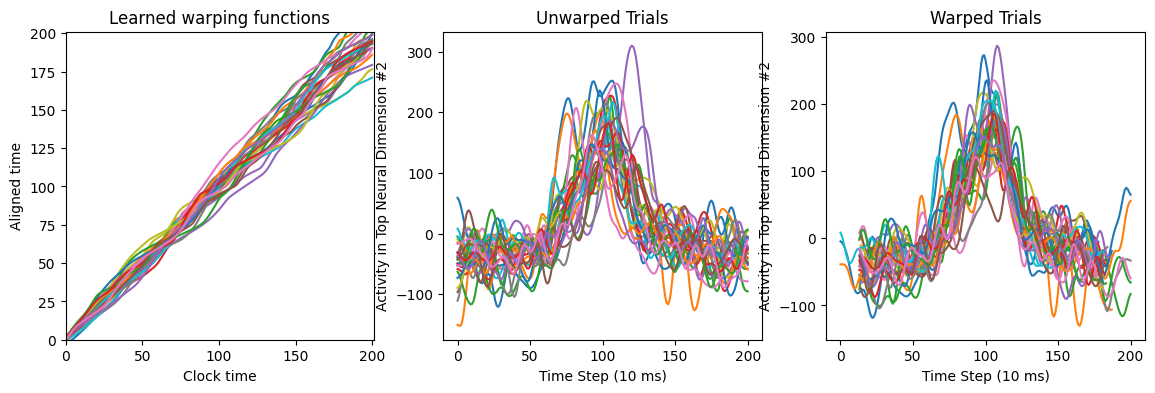

Warping character: u


/var/folders/n_/8p1gdnb570j4m06ltsyf5d1w0000gn/T/ipykernel_77119/1514026267.py:54: DeprecationWarning: Please import `gaussian_filter1d` from the `scipy.ndimage` namespace; the `scipy.ndimage.filters` namespace is deprecated and will be removed in SciPy 2.0.0.
  smoothed_spikes = scipy.ndimage.filters.gaussian_filter1d(dat['neuralActivityCube_'+char], 3.0, axis=1)
2025-06-16 22:07:46.695555: W tensorflow/c/c_api.cc:305] Operation '{name:'tau_scale_51/Assign' id:1348049 op device:{requested: '', assigned: ''} def:{{{node tau_scale_51/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](tau_scale_51, tau_scale_51/Initializer/initial_value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2025-06-16 22:08:39.217383: W tensorflow/c/c_api.cc:305] Operation '{name:'tau_shift_51/A

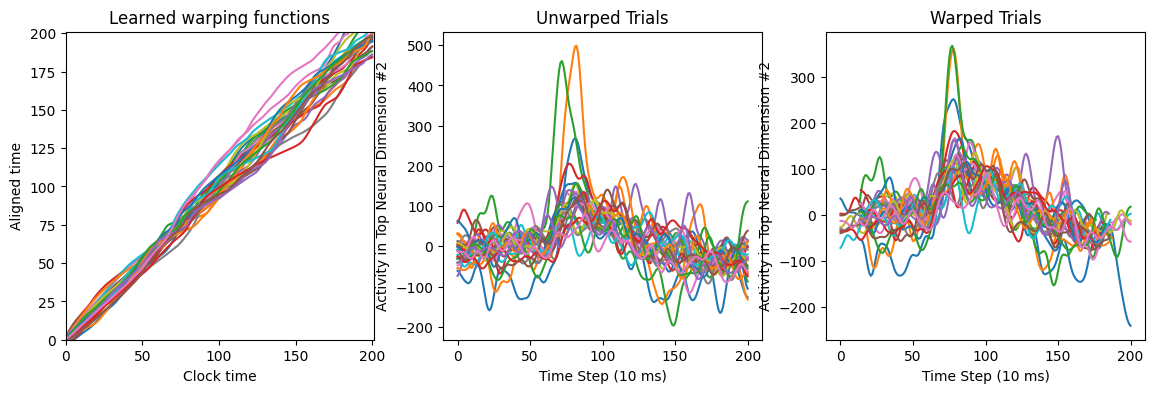

Warping character: v


/var/folders/n_/8p1gdnb570j4m06ltsyf5d1w0000gn/T/ipykernel_77119/1514026267.py:54: DeprecationWarning: Please import `gaussian_filter1d` from the `scipy.ndimage` namespace; the `scipy.ndimage.filters` namespace is deprecated and will be removed in SciPy 2.0.0.
  smoothed_spikes = scipy.ndimage.filters.gaussian_filter1d(dat['neuralActivityCube_'+char], 3.0, axis=1)
2025-06-16 22:10:13.320142: W tensorflow/c/c_api.cc:305] Operation '{name:'tau_scale_52/Assign' id:1375807 op device:{requested: '', assigned: ''} def:{{{node tau_scale_52/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](tau_scale_52, tau_scale_52/Initializer/initial_value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2025-06-16 22:11:10.755646: W tensorflow/c/c_api.cc:305] Operation '{name:'tau_shift_52/A

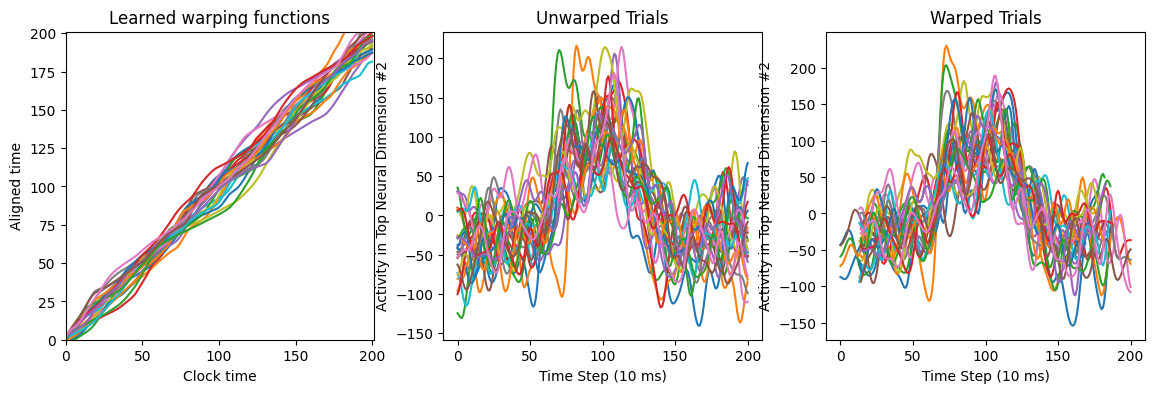

Warping character: w


/var/folders/n_/8p1gdnb570j4m06ltsyf5d1w0000gn/T/ipykernel_77119/1514026267.py:54: DeprecationWarning: Please import `gaussian_filter1d` from the `scipy.ndimage` namespace; the `scipy.ndimage.filters` namespace is deprecated and will be removed in SciPy 2.0.0.
  smoothed_spikes = scipy.ndimage.filters.gaussian_filter1d(dat['neuralActivityCube_'+char], 3.0, axis=1)
2025-06-16 22:12:52.534823: W tensorflow/c/c_api.cc:305] Operation '{name:'tau_scale_53/Assign' id:1403616 op device:{requested: '', assigned: ''} def:{{{node tau_scale_53/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](tau_scale_53, tau_scale_53/Initializer/initial_value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2025-06-16 22:13:46.929925: W tensorflow/c/c_api.cc:305] Operation '{name:'tau_shift_53/A

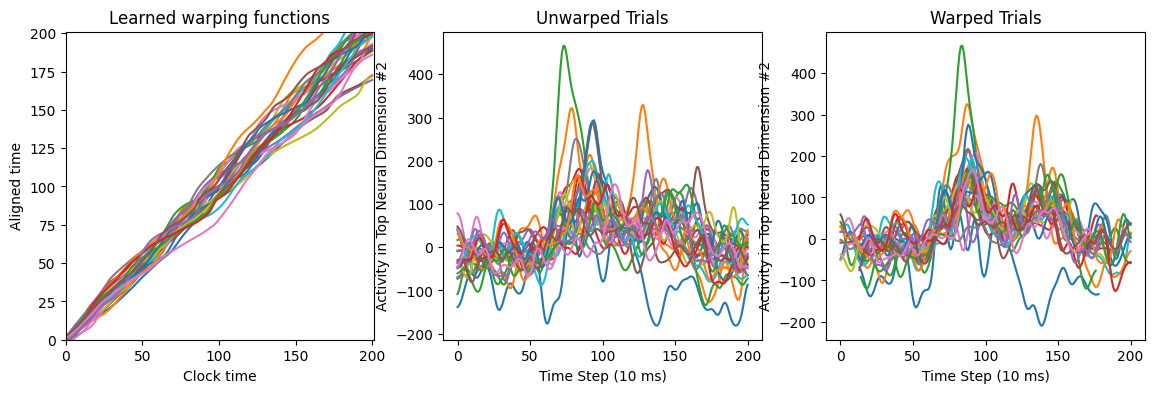

Warping character: x


/var/folders/n_/8p1gdnb570j4m06ltsyf5d1w0000gn/T/ipykernel_77119/1514026267.py:54: DeprecationWarning: Please import `gaussian_filter1d` from the `scipy.ndimage` namespace; the `scipy.ndimage.filters` namespace is deprecated and will be removed in SciPy 2.0.0.
  smoothed_spikes = scipy.ndimage.filters.gaussian_filter1d(dat['neuralActivityCube_'+char], 3.0, axis=1)
2025-06-16 22:15:27.370920: W tensorflow/c/c_api.cc:305] Operation '{name:'tau_scale_54/Assign' id:1431476 op device:{requested: '', assigned: ''} def:{{{node tau_scale_54/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](tau_scale_54, tau_scale_54/Initializer/initial_value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2025-06-16 22:16:22.441628: W tensorflow/c/c_api.cc:305] Operation '{name:'tau_shift_54/A

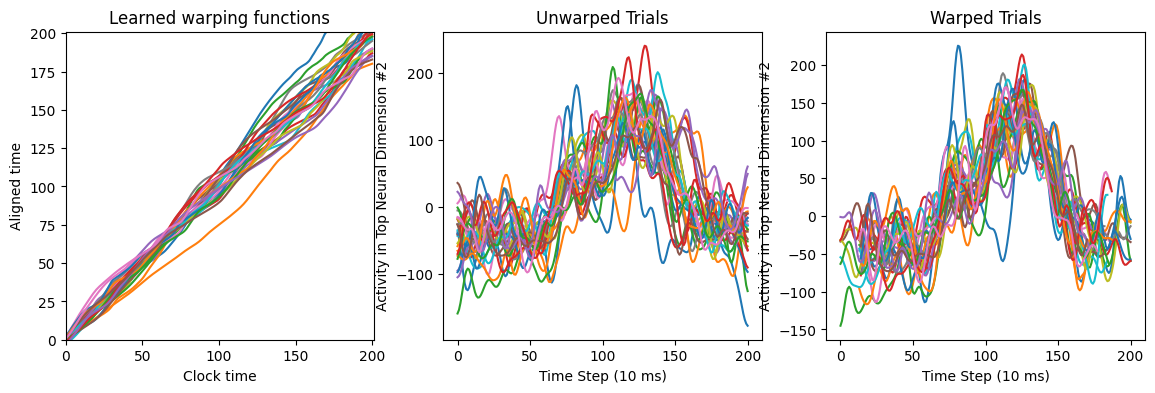

Warping character: y


/var/folders/n_/8p1gdnb570j4m06ltsyf5d1w0000gn/T/ipykernel_77119/1514026267.py:54: DeprecationWarning: Please import `gaussian_filter1d` from the `scipy.ndimage` namespace; the `scipy.ndimage.filters` namespace is deprecated and will be removed in SciPy 2.0.0.
  smoothed_spikes = scipy.ndimage.filters.gaussian_filter1d(dat['neuralActivityCube_'+char], 3.0, axis=1)
2025-06-16 22:18:04.476748: W tensorflow/c/c_api.cc:305] Operation '{name:'tau_scale_55/Assign' id:1459387 op device:{requested: '', assigned: ''} def:{{{node tau_scale_55/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](tau_scale_55, tau_scale_55/Initializer/initial_value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2025-06-16 22:19:01.434305: W tensorflow/c/c_api.cc:305] Operation '{name:'tau_shift_55/A

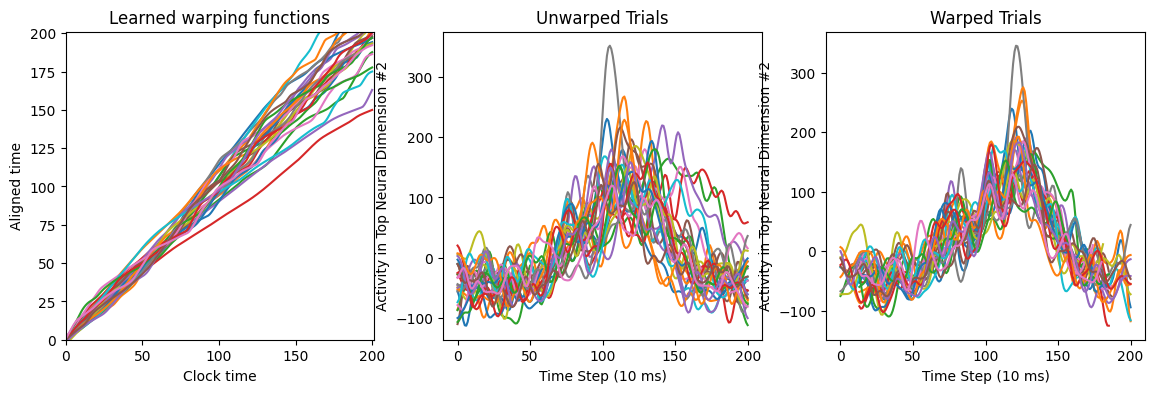

Warping character: z


/var/folders/n_/8p1gdnb570j4m06ltsyf5d1w0000gn/T/ipykernel_77119/1514026267.py:54: DeprecationWarning: Please import `gaussian_filter1d` from the `scipy.ndimage` namespace; the `scipy.ndimage.filters` namespace is deprecated and will be removed in SciPy 2.0.0.
  smoothed_spikes = scipy.ndimage.filters.gaussian_filter1d(dat['neuralActivityCube_'+char], 3.0, axis=1)
2025-06-16 22:20:52.264563: W tensorflow/c/c_api.cc:305] Operation '{name:'tau_scale_56/Assign' id:1487349 op device:{requested: '', assigned: ''} def:{{{node tau_scale_56/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](tau_scale_56, tau_scale_56/Initializer/initial_value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2025-06-16 22:21:49.719012: W tensorflow/c/c_api.cc:305] Operation '{name:'tau_shift_56/A

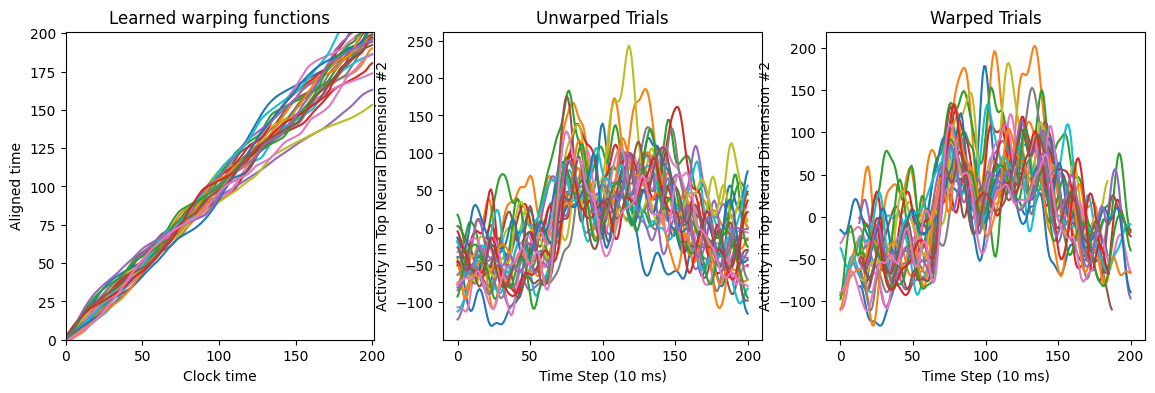

Warping character: greaterThan


/var/folders/n_/8p1gdnb570j4m06ltsyf5d1w0000gn/T/ipykernel_77119/1514026267.py:54: DeprecationWarning: Please import `gaussian_filter1d` from the `scipy.ndimage` namespace; the `scipy.ndimage.filters` namespace is deprecated and will be removed in SciPy 2.0.0.
  smoothed_spikes = scipy.ndimage.filters.gaussian_filter1d(dat['neuralActivityCube_'+char], 3.0, axis=1)
2025-06-16 22:23:37.384070: W tensorflow/c/c_api.cc:305] Operation '{name:'tau_scale_57/Assign' id:1515362 op device:{requested: '', assigned: ''} def:{{{node tau_scale_57/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](tau_scale_57, tau_scale_57/Initializer/initial_value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2025-06-16 22:24:36.719536: W tensorflow/c/c_api.cc:305] Operation '{name:'tau_shift_57/A

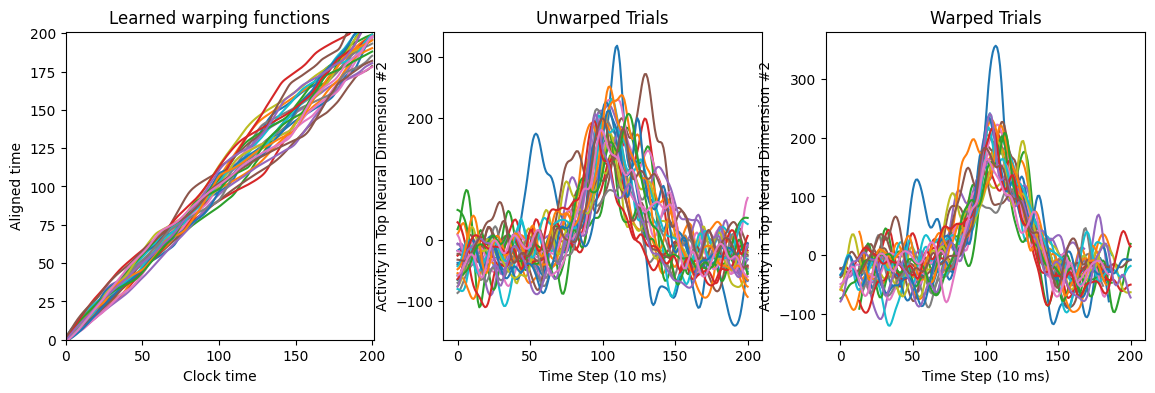

Warping character: comma


/var/folders/n_/8p1gdnb570j4m06ltsyf5d1w0000gn/T/ipykernel_77119/1514026267.py:54: DeprecationWarning: Please import `gaussian_filter1d` from the `scipy.ndimage` namespace; the `scipy.ndimage.filters` namespace is deprecated and will be removed in SciPy 2.0.0.
  smoothed_spikes = scipy.ndimage.filters.gaussian_filter1d(dat['neuralActivityCube_'+char], 3.0, axis=1)
2025-06-16 22:26:27.799543: W tensorflow/c/c_api.cc:305] Operation '{name:'tau_scale_58/Assign' id:1543426 op device:{requested: '', assigned: ''} def:{{{node tau_scale_58/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](tau_scale_58, tau_scale_58/Initializer/initial_value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2025-06-16 22:27:26.813800: W tensorflow/c/c_api.cc:305] Operation '{name:'tau_shift_58/A

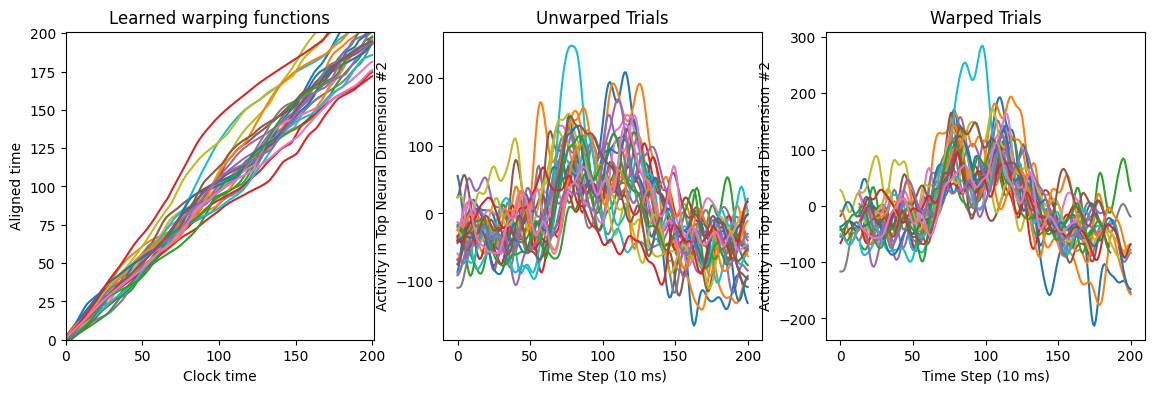

Warping character: apostrophe


/var/folders/n_/8p1gdnb570j4m06ltsyf5d1w0000gn/T/ipykernel_77119/1514026267.py:54: DeprecationWarning: Please import `gaussian_filter1d` from the `scipy.ndimage` namespace; the `scipy.ndimage.filters` namespace is deprecated and will be removed in SciPy 2.0.0.
  smoothed_spikes = scipy.ndimage.filters.gaussian_filter1d(dat['neuralActivityCube_'+char], 3.0, axis=1)
2025-06-16 22:29:16.791142: W tensorflow/c/c_api.cc:305] Operation '{name:'tau_scale_59/Assign' id:1571541 op device:{requested: '', assigned: ''} def:{{{node tau_scale_59/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](tau_scale_59, tau_scale_59/Initializer/initial_value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2025-06-16 22:30:17.352306: W tensorflow/c/c_api.cc:305] Operation '{name:'tau_shift_59/A

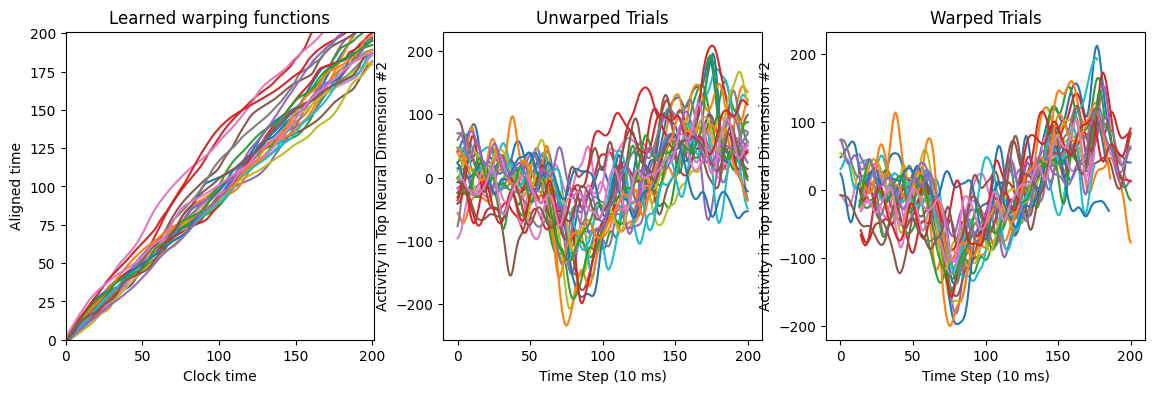

Warping character: tilde


/var/folders/n_/8p1gdnb570j4m06ltsyf5d1w0000gn/T/ipykernel_77119/1514026267.py:54: DeprecationWarning: Please import `gaussian_filter1d` from the `scipy.ndimage` namespace; the `scipy.ndimage.filters` namespace is deprecated and will be removed in SciPy 2.0.0.
  smoothed_spikes = scipy.ndimage.filters.gaussian_filter1d(dat['neuralActivityCube_'+char], 3.0, axis=1)
2025-06-16 22:32:08.860121: W tensorflow/c/c_api.cc:305] Operation '{name:'tau_scale_60/Assign' id:1599707 op device:{requested: '', assigned: ''} def:{{{node tau_scale_60/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](tau_scale_60, tau_scale_60/Initializer/initial_value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2025-06-16 22:33:10.523452: W tensorflow/c/c_api.cc:305] Operation '{name:'tau_shift_60/A

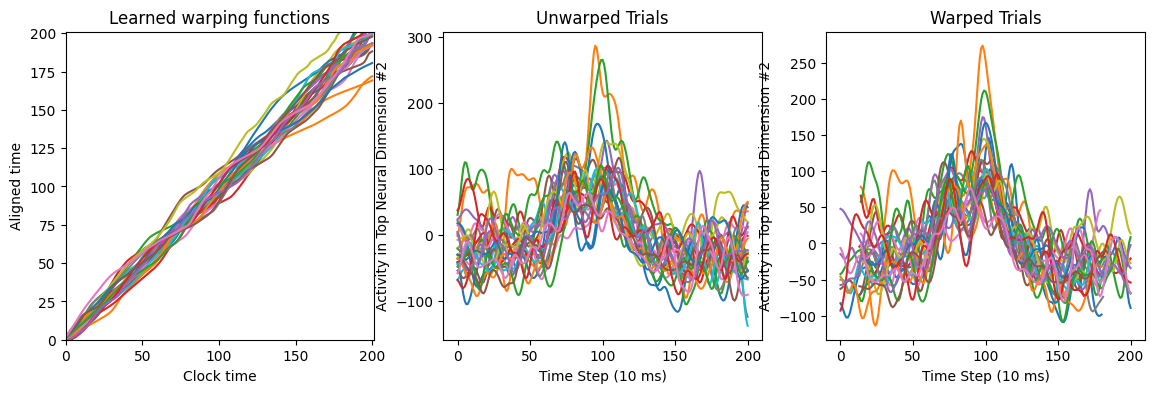

Warping character: questionMark


/var/folders/n_/8p1gdnb570j4m06ltsyf5d1w0000gn/T/ipykernel_77119/1514026267.py:54: DeprecationWarning: Please import `gaussian_filter1d` from the `scipy.ndimage` namespace; the `scipy.ndimage.filters` namespace is deprecated and will be removed in SciPy 2.0.0.
  smoothed_spikes = scipy.ndimage.filters.gaussian_filter1d(dat['neuralActivityCube_'+char], 3.0, axis=1)
2025-06-16 22:35:06.104068: W tensorflow/c/c_api.cc:305] Operation '{name:'tau_scale_61/Assign' id:1627924 op device:{requested: '', assigned: ''} def:{{{node tau_scale_61/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](tau_scale_61, tau_scale_61/Initializer/initial_value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2025-06-16 22:36:08.624953: W tensorflow/c/c_api.cc:305] Operation '{name:'tau_shift_61/A

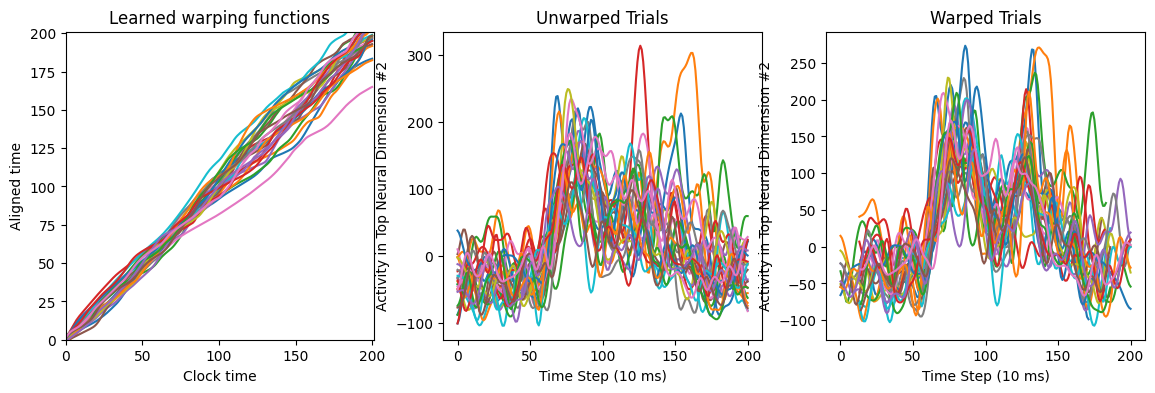

Saving /Users/seanmacpherson/clones/willets-2021-handwriting-bci/warped-data/_warpedCubes.mat


FileNotFoundError: [Errno 2] No such file or directory: '/Users/seanmacpherson/clones/willets-2021-handwriting-bci/warped-data/_warpedCubes.mat'

In [20]:
#Time-warp all singleLetters.mat files and save them to the Step1_TimeWarping folder
for dataDir in dataDirs:
    
    print('Warping dataset: ' + dataDir)
    #Because baseline firing rates drift over time, we normalize each electrode's firing rate by subtracting
    #its mean firing rate within each block of data (re-centering it). We also divide by each electrode's standard deviation 
    #to normalize the units.
    for char in charDef['charList']:
        neuralCube = dat['neuralActivityCube_'+char].astype(np.float64)

        #get the trials that belong to this character
        trlIdx = []
        for t in range(dat['characterCues'].shape[0]):
            if dat['characterCues'][t,0]==char:
                trlIdx.append(t)

        #get the block that each trial belonged to
        blockIdx = dat['blockNumsTimeSeries'][dat['goPeriodOnsetTimeBin'][trlIdx]]
        blockIdx = np.squeeze(blockIdx)

        #subtract block-specific means from each trial 
        for b in range(dat['blockList'].shape[0]):
            trialsFromThisBlock = np.squeeze(blockIdx==dat['blockList'][b])
            neuralCube[trialsFromThisBlock,:,:] -= dat['meansPerBlock'][np.newaxis,b,:]

        #divide by standard deviation to normalize the units
        neuralCube = neuralCube / dat['stdAcrossAllData'][np.newaxis,:,:]

        #replace the original cube with this newly normalized one
        dat['neuralActivityCube_'+char] = neuralCube
    
    alignedDat = {}
    
    #The following warps each character one at a time. 
    #(this is slow, and could be sped up significantly by warping multiple characters in parallel)
    for char in charDef['charList']:
        print('Warping character: ' + char)

        #Clears the previous character's graph
        # tf.reset_default_graph()

        #Number of factors used to denoise the data while time-warping (by approximating data with low-rank matrices)
        n_components = 5

        #Adds an L1 penalty on the second order finite difference of the warping functions.
        #This encourages the warping functions to be piecewise linear.
        warp_regularizer = curvature(scale=0.001, power=1)

        #Adds an L2 penatly on the second order finite difference of the temporal factors.
        #Encourages the temporal factors to be smooth in time.
        time_regularizer = curvature(scale=1.0, power=2, axis=0)

        # Smooths the binned spike counts before time-warping to denoise them (this step is key!)
        smoothed_spikes = scipy.ndimage.filters.gaussian_filter1d(dat['neuralActivityCube_'+char], 3.0, axis=1)

        # fit time-warping model
        model = TWPCA(smoothed_spikes, 
                      n_components, 
                      warp_regularizer=warp_regularizer, 
                      time_regularizer=time_regularizer).fit(progressbar=False)

        # use the model object to align data 
        estimated_aligned_data = model.transform(dat['neuralActivityCube_'+char])
        smoothed_aligned_data = scipy.ndimage.filters.gaussian_filter1d(estimated_aligned_data, 3.0, axis=1)

        #store aligned data and time-warping functions
        alignedDat[char] = estimated_aligned_data
        alignedDat[char+'_T'] = model.params['warp'].T.copy()

        #only make plots for the first session (otherwise the notebook gets too big)
        if dataDir!='t5.2019.05.08':
            continue
            
        #plot the warping functions to make sure they look reasonable (should be subtle deviations from the identity line)
        plt.figure(figsize=(14,4))
        plt.subplot(1,3,1)
        plt.plot(model.params['warp'].T, alpha=1);
        plt.axis('square')
        plt.xlabel('Clock time')
        plt.ylabel('Aligned time')
        plt.xlim(0, model.params['warp'].T.shape[0]);
        plt.ylim(0, model.params['warp'].T.shape[0])
        plt.title('Learned warping functions')
        
        #It's helpful also to visualize how the major dimensions in the data were aligned
        #We chose dimension 2 here, because the top dimension isn't as informative (it's just a large spike at movement onset)
        neuron_factors = model.params['neuron']
        plt.subplot(1,3,2)
        for t in range(estimated_aligned_data.shape[0]):
            thisTrialActivity = np.matmul(smoothed_spikes[t,:,:], neuron_factors)
            plt.plot(thisTrialActivity[:,1])
            
        plt.title('Unwarped Trials')
        plt.xlabel('Time Step (10 ms)')
        plt.ylabel('Activity in Top Neural Dimension #2')
        
        plt.subplot(1,3,3)
        for t in range(estimated_aligned_data.shape[0]):
            thisTrialWarpedActivity = np.matmul(smoothed_aligned_data[t,:,:], neuron_factors)
            plt.plot(thisTrialWarpedActivity[:,1])
        
        plt.title('Warped Trials')
        plt.xlabel('Time Step (10 ms)')
        plt.ylabel('Activity in Top Neural Dimension #2')
        
        plt.show()
        
    #save time-warped characters as a .mat file        
    fileName = rootDir + '/warped-data' + '/_warpedCubes.mat'
    print('Saving ' + fileName)
    scipy.io.savemat(fileName, alignedDat)
    